<a href="https://colab.research.google.com/github/yk-162/alzheimerMRI/blob/main/alzheimerMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
kaggle.json


In [2]:
# download dataset from kaggle
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset
License(s): copyright-authors
alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile

with zipfile.ZipFile('/content/alzheimer-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/alzheimer-mri-dataset')

In [4]:
# import libraries

import os
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time

In [5]:
# load datasets

DATA_SET_PATH = r'/content/alzheimer-mri-dataset/Dataset'
categories=os.listdir(DATA_SET_PATH)

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data = ImageFolder(DATA_SET_PATH, transform=data_transform)

In [6]:
# splitting datasets into training, testing and validation

n = len(data)
n_test = int(n * 0.2)  # 20% for test
n_train = n - n_test  # 80% for train
n_val = int(n_test * 0.5)  # 10% for validation (50% from test)
train_data, test_data = random_split(data, [n_train, n_test], torch.Generator().manual_seed(75))
test_data, val_data = random_split(test_data, [n_val, n_val], torch.Generator().manual_seed(75))

batch_size = 128
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [7]:
# build CNN model
# convolutional layer to extract features from the image at input layer
# pooling layer to speed up the processing of the model (by compressing data)
# fully connected layers to get the predictions about the images with their categories

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.dropout = nn.Dropout(0.5)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 8 * 8, 32),
            nn.ReLU()
        )

        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = F.log_softmax(x, dim=1)
        #x = F.softmax(x, dim=1)
        return x

In [8]:
model = ConvNet()
# print(summary(model, (3, 128, 128)))

In [9]:
# optimizer and loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [10]:
# train the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    # start_t = 0
    # end_t = 0
    # epoch_t = 0
    # start_t = time.time()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_func(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += (outputs.argmax(dim=1) == labels).type(torch.float).sum().item()
        train_loss += loss.item()

    train_acc /= len(trainloader.dataset)
    train_loss /= len(trainloader)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    # end_t = time.time()
    # epoch_t = end_t - start_t  # time used for each epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")
    # print(f'Time: {epoch_t:.2f} seconds')


    model.eval()
    total = 0
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = model(images)
            loss = loss_func(outputs, labels)

            total += labels.size(0)
            val_acc += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            val_loss += loss.item()

    val_acc /= len(valloader.dataset)
    val_loss /= len(valloader)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc*100:.2f}%")

Epoch 1/30, Train Loss: 1.0168, Train Accuracy: 50.98%
Validation Loss: 0.9374, Validation Accuracy: 52.97%
Epoch 2/30, Train Loss: 0.9467, Train Accuracy: 53.30%
Validation Loss: 0.9237, Validation Accuracy: 56.56%
Epoch 3/30, Train Loss: 0.9333, Train Accuracy: 54.63%
Validation Loss: 0.8979, Validation Accuracy: 57.50%
Epoch 4/30, Train Loss: 0.9065, Train Accuracy: 56.17%
Validation Loss: 0.8754, Validation Accuracy: 60.00%
Epoch 5/30, Train Loss: 0.8850, Train Accuracy: 57.54%
Validation Loss: 0.8685, Validation Accuracy: 59.69%
Epoch 6/30, Train Loss: 0.8609, Train Accuracy: 59.26%
Validation Loss: 0.8271, Validation Accuracy: 62.66%
Epoch 7/30, Train Loss: 0.8212, Train Accuracy: 61.99%
Validation Loss: 0.8195, Validation Accuracy: 61.41%
Epoch 8/30, Train Loss: 0.7824, Train Accuracy: 63.98%
Validation Loss: 0.7432, Validation Accuracy: 68.75%
Epoch 9/30, Train Loss: 0.7337, Train Accuracy: 66.25%
Validation Loss: 0.7001, Validation Accuracy: 69.84%
Epoch 10/30, Train Loss: 0.6

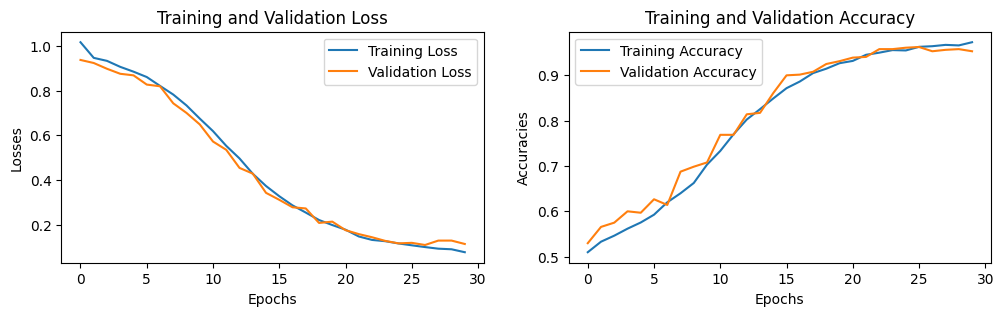

In [11]:
# plot the loss and accuracy values over epochs

epoch_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_losses, label='Training Loss')
plt.plot(epoch_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_accuracies, label='Training Accuracy')
plt.plot(epoch_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [12]:
# prediction for each category
class_correct = [0. for _ in range(len(categories))]
class_total = [0. for _ in range(len(categories))]

y_preds = []
y_true = []

correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        total += labels.size(0)

        y_preds.append(predicted.numpy())
        y_true.append(labels.numpy())
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

    for i in range(len(categories)):
        print(f'Accuracy of {categories[i]} : {100 * class_correct[i] / class_total[i]:.2f} %')

print(f'Accuracy: {100*correct//total}%')

Accuracy of Very_Mild_Demented : 91.40 %
Accuracy of Moderate_Demented : 87.50 %
Accuracy of Mild_Demented : 96.10 %
Accuracy of Non_Demented : 98.27 %
Accuracy: 96%
